bagging : 기존 모델들을 조합    
머신러닝은 앙상블이다 라고 생각해도 무방할정도로 중요하다

# 앙상블
- 여러개의 분류모델을 조합해서 더 나은 성능을 내는 방법

## RandomForest
: 의사결정트리 bagging(단일 모델 조합)해서 예측을 실행하는 모델

In [1]:
from sklearn import datasets

import numpy as np
np.random.seed(5)

In [2]:
# 손글씨 데이터
mnist = datasets.load_digits()
features , labels = mnist.data , mnist.target

In [4]:
len(mnist.data) # array 로 들어가 있음

1797

In [13]:
labels

array([0, 1, 2, ..., 8, 9, 8])

In [14]:
# 의사결정 나무를 이용한 10번의 교차 검증 10번 실시
from sklearn import tree
from sklearn.model_selection import cross_val_score

cv_scores = []
ct = tree.DecisionTreeClassifier()

for i in range(10):
    scores = cross_val_score(ct , features , labels , cv = 10 , scoring='accuracy') 
    cv_scores.append(scores.mean())

cv_scores

[0.8252731222842955,
 0.823026070763501,
 0.8319180633147113,
 0.8230074487895717,
 0.8263687150837988,
 0.8319242706393544,
 0.8291620111731843,
 0.8341495965238982,
 0.8296803227808814,
 0.8219180633147113]

In [15]:
# RandomForest를 이용한 교차검증(10회) 10번
from sklearn.ensemble import RandomForestClassifier

cv_scores = []
rf = RandomForestClassifier()

for i in range(10):
    scores = cross_val_score(rf , features , labels , cv = 10 , scoring='accuracy')
    cv_scores.append(scores.mean())

cv_scores

[0.9465673494723774,
 0.9476939788950961,
 0.9510086902545002,
 0.9549099937926753,
 0.9471260086902544,
 0.9454593420235877,
 0.9510335195530726,
 0.9499130974549969,
 0.9488019863438858,
 0.94768156424581]

In [20]:
def cross_validation(model, X_train , y_train ):
    list_scores = []
    for i in range(10):
        scores = cross_val_score( model , X_train , y_train , cv = 10 , scoring='accuracy')
        list_scores.append(scores.mean())
    return list_scores

In [21]:
# 의사결정나무
dt_cv_scores = cross_validation( tree.DecisionTreeClassifier() , features , labels)
dt_cv_scores

[0.8291558038485413,
 0.8219025450031037,
 0.8219025450031037,
 0.8341620111731844,
 0.8369273743016759,
 0.8241527001862197,
 0.8335878336436995,
 0.8229981378026071,
 0.82967721911856,
 0.8252234636871508]

In [22]:
# RandomForest
rf_cv_scores = cross_validation( RandomForestClassifier(), features, labels)
rf_cv_scores

[0.9510211049037863,
 0.9499006828057107,
 0.9532495344506516,
 0.9510273122284294,
 0.9526908752327745,
 0.9487988826815641,
 0.946582867783985,
 0.9499099937926753,
 0.9526846679081314,
 0.949366852886406]

### 랜덤포레스트와 의사결정나무의 정확도 시각화

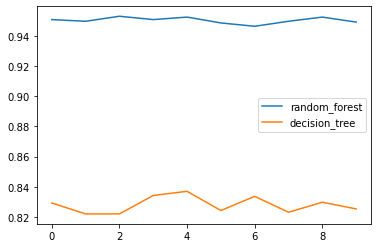

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

cv_list = {'random_forest' : rf_cv_scores, 'decision_tree' : dt_cv_scores}
df = pd.DataFrame(cv_list)
df.plot()
plt.show()

# 앙상블 한것(랜덤포레스트)과 안 한것(의사결정나무)의 차이

---
# 보팅(voting) 앙상블
: 단일 모델을 앙상블하여 더 나은 예측을 하는 모델 생성  
// 투표, 2~3개 모델 후보를 두고 그때그때 적합한 모델을 사용하게 한다

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= 0.2)

### 단일 모델 정확도 특정

In [44]:
# 의사결정나무
dtree = tree.DecisionTreeClassifier().fit(X_train, y_train)
dtree_score = dtree.score(X_test, y_test)
print("dtree :", dtree_score)

dtree : 0.8583333333333333


In [45]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print("KNN :",knn_score)

KNN : 0.9944444444444445


In [46]:
# SVM
from sklearn.svm import SVC
svm = SVC(probability = True).fit(X_train, y_train) # probability=True 수치 내놓음
svm_score = svm.score(X_test, y_test)
print("SVM :", svm_score)

SVM : 0.9944444444444445


### 하드 보팅
: 각각의 분류기의 예측값들을 모아, 가장 많은 득표를 받은 예측값으로 최종 결론을 내는 방식 입니다.   
// count, 

In [47]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators = [('decision_tree', dtree) , ('knn',knn,), ('svm', svm)], # 위에서 단일 모델 학습시킨 것들
    weights=[1,1,1], # (투표권한) 가중치 y^=wX+B에서 w(기울기)이다. knn, svm이 정확도가 더 높기 때문에 더 많이 줘야 하지만 지금은 1로 동일하게 줌,
    voting= 'hard',
).fit(X_train, y_train)

voting_clf.score(X_test, y_test)

0.9944444444444445

### 소프트 보팅
: 각각의 분류모델을 활용하여 모든 분류값들의 확률들을 더해서 가장 높은 점수를 획득한 분류값으로 최종결론을 내는 방식입니다.     
// 확률 , 나중에 가면 좋음 . 과대적합이 안 생김

In [48]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators = [('decision_tree', dtree) , ('knn',knn,), ('svm', svm)], # 위에서 단일 모델 학습시킨 것들
    weights=[1,1,1], # (투표권한) 가중치 y^=wX+B에서 w(기울기)이다. knn, svm이 정확도가 더 높기 때문에 더 많이 줘야 하지만 지금은 1로 동일하게 줌,
    voting= 'soft',
).fit(X_train, y_train)

voting_clf.score(X_test, y_test)

0.9861111111111112

---